# Regression Model for Kaggle Tabular Playground Series Feb 2021 Using Python and Scikit-learn
### David Lowe
### May 25, 2021

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Kaggle Tabular Playground Series Feb 2021 dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Kaggle wants to provide an approachable environment for relatively new people in their data science journey. Since January 2021, they have hosted playground-style competitions on Kaggle with fun but less complex, tabular datasets. The February dataset may be synthetic but is based on a real dataset and generated using a CTGAN. The original dataset tries to predict the amount of an insurance claim. Although the features are anonymized, they have properties relating to real-world features.

ANALYSIS: The average performance of the machine learning algorithms achieved an RMSE benchmark of 0.7728 using the training dataset. We selected Random Forest and Gradient Boosting to perform the tuning exercises. After a series of tuning trials, the refined Gradient Boosting model processed the training dataset with a final RMSE score of 0.7135. When we processed Kaggle's test dataset with the final model, the model achieved an RMSE score of 0.8455.

CONCLUSION: In this iteration, the Gradient Boosting model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Kaggle Tabular Playground Series Feb 2021 Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/tabular-playground-series-feb-2021

One potential source of performance benchmarks: https://www.kaggle.com/c/tabular-playground-series-feb-2021/leaderboard

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Fine-tune and Improve Models
6. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 4

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.25

# Set the number of folds for cross validation
N_FOLDS = 5

# Set various default modeling parameters
SCORING_METRIC = 'neg_mean_squared_error'

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/train.csv'
df_dataset_import = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12  \
0   1    A    B    A    A    B    D    A    E    C  ...  0.881122  0.421650  0.741413  0.895799  0.802461  0.724417  0.701915  0.877618   
1   2    B    A    A    A    B    B    A    E    A  ...  0.440011  0.346230  0.278495  0.593413  0.546056  0.613252  0.741289  0.326679   
2   3    A    A    A    C    B    D    A    B    C  ...  0.914155  0.369602  0.832564  0.865620  0.825251  0.264104  0.695561  0.869133   
3   4    A    A    A    C    B    D    A    E    G  ...  0.934138  0.578930  0.407313  0.868099  0.794402  0.494269  0.698125  0.809799   
4   6    A    B    A    A    B    B    A    E    C  ...  0.382600  0.705940  0.325193  0.440967  0.462146  0.724447  0.683073  0.343457   

     cont13    target  
0  0.719903  6.994023  
1  0.808464  8.071256  
2  0.828352  5.760456  
3  0.614766  7.806457  
4  0.297743  6.868974  

[5 rows x 26 columns

In [11]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

In [12]:
print(df_dataset_import.describe())

                  id          cont0          cont1          cont2          cont3          cont4          cont5          cont6  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean   250018.576947       0.524634       0.506649       0.444115       0.446214       0.455471       0.508337       0.478345   
std    144450.150010       0.204875       0.235269       0.200089       0.238669       0.200695       0.231612       0.192432   
min         1.000000      -0.093505      -0.055105      -0.060274       0.134760       0.189216      -0.087247       0.043953   
25%    124772.500000       0.370451       0.352307       0.314121       0.214572       0.279853       0.338747       0.339896   
50%    250002.500000       0.492208       0.615156       0.457271       0.377823       0.411351       0.441384       0.410090   
75%    375226.500000       0.654793       0.688150       0.554835       0.719758       0.621808  

In [13]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

id        0
cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [14]:
# Dropping features
df_dataset_import.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont5     cont6     cont7     cont8     cont9    cont10    cont11    cont12  \
0    A    B    A    A    B    D    A    E    C    I  ...  0.881122  0.421650  0.741413  0.895799  0.802461  0.724417  0.701915  0.877618   
1    B    A    A    A    B    B    A    E    A    F  ...  0.440011  0.346230  0.278495  0.593413  0.546056  0.613252  0.741289  0.326679   
2    A    A    A    C    B    D    A    B    C    N  ...  0.914155  0.369602  0.832564  0.865620  0.825251  0.264104  0.695561  0.869133   
3    A    A    A    C    B    D    A    E    G    K  ...  0.934138  0.578930  0.407313  0.868099  0.794402  0.494269  0.698125  0.809799   
4    A    B    A    A    B    B    A    E    C    F  ...  0.382600  0.705940  0.325193  0.440967  0.462146  0.724447  0.683073  0.343457   

     cont13    target  
0  0.719903  6.994023  
1  0.808464  8.071256  
2  0.828352  5.760456  
3  0.614766  7.806457  
4  0.297743  6.868974  

[5 rows x 25 c

In [15]:
print(df_dataset_import.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [16]:
print(df_dataset_import.describe())

               cont0          cont1          cont2          cont3          cont4          cont5          cont6          cont7  \
count  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000  300000.000000   
mean        0.524634       0.506649       0.444115       0.446214       0.455471       0.508337       0.478345       0.455904   
std         0.204875       0.235269       0.200089       0.238669       0.200695       0.231612       0.192432       0.204493   
min        -0.093505      -0.055105      -0.060274       0.134760       0.189216      -0.087247       0.043953       0.208703   
25%         0.370451       0.352307       0.314121       0.214572       0.279853       0.338747       0.339896       0.278041   
50%         0.492208       0.615156       0.457271       0.377823       0.411351       0.441384       0.410090       0.360736   
75%         0.654793       0.688150       0.554835       0.719758       0.621808       0.709515  

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

cat0      0
cat1      0
cat2      0
cat3      0
cat4      0
cat5      0
cat6      0
cat7      0
cat8      0
cat9      0
cont0     0
cont1     0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
cont10    0
cont11    0
cont12    0
cont13    0
target    0
dtype: int64
Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [18]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# target_column_position variable indicates the column location of the target/class variable
# If the first column, set target_column_position to 1. If the last column, set target_column_position to total_column_count
# If (target_column_position <> 1) and (target_column_position <> total_column_count), be aware when slicing up the dataframes for visualization
target_column_position = total_column_count

In [19]:
# We create attribute-only and target-only datasets (df_features_train and df_target_train)
# for various visualization and cleaning/transformation operations

if target_column_position == total_column_count:
    df_features_train = df_dataset_import.iloc[:,0:total_feature_count]
    df_target_train = df_dataset_import.iloc[:,total_feature_count]
else:
    df_features_train = df_dataset_import.iloc[:,1:total_column_count]
    df_target_train = df_dataset_import.iloc[:,0]

print("df_dataset_import.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_import.shape, df_features_train.shape, df_target_train.shape))

df_dataset_import.shape: (300000, 25) df_features_train.shape: (300000, 24) df_target_train.shape: (300000,)


### 1.f) Set up the parameters for data visualization

In [20]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [21]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [22]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


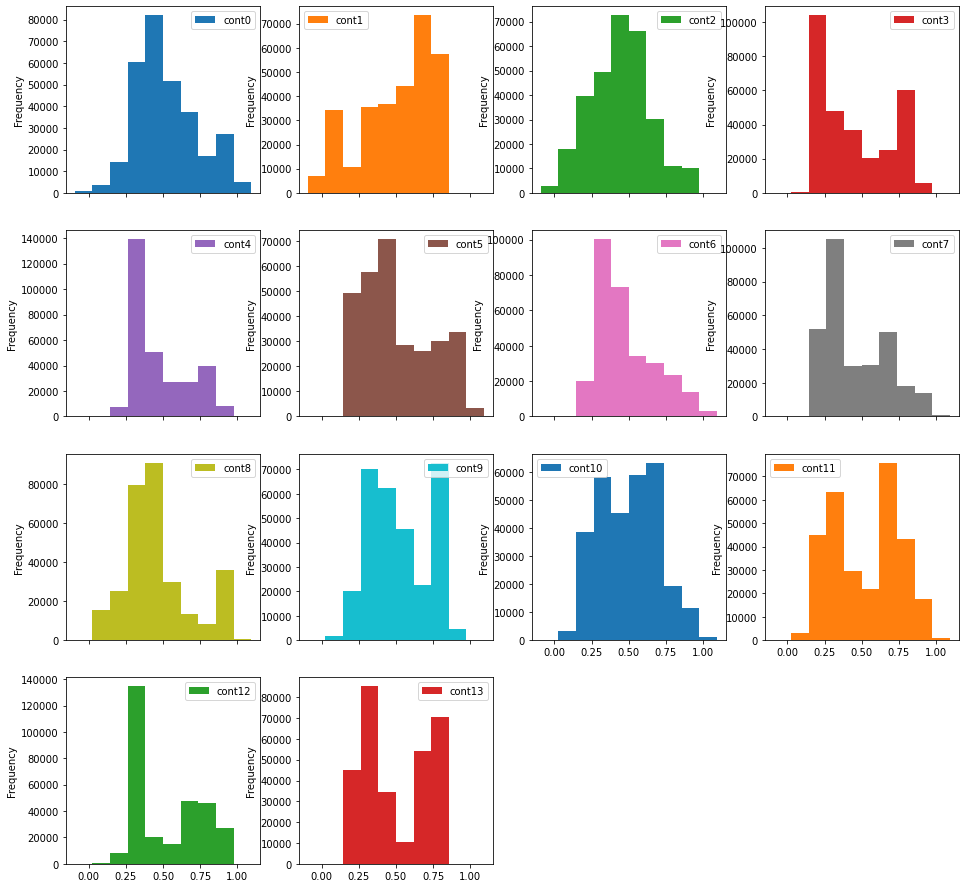

In [23]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

/usr/local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


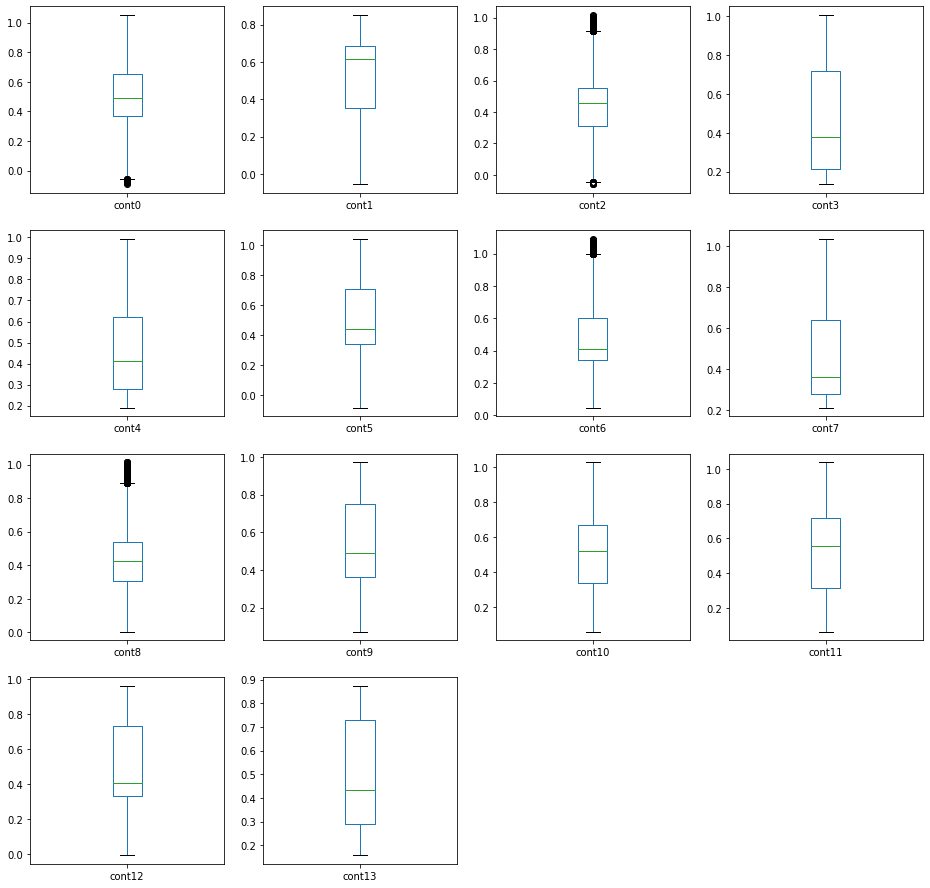

In [24]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

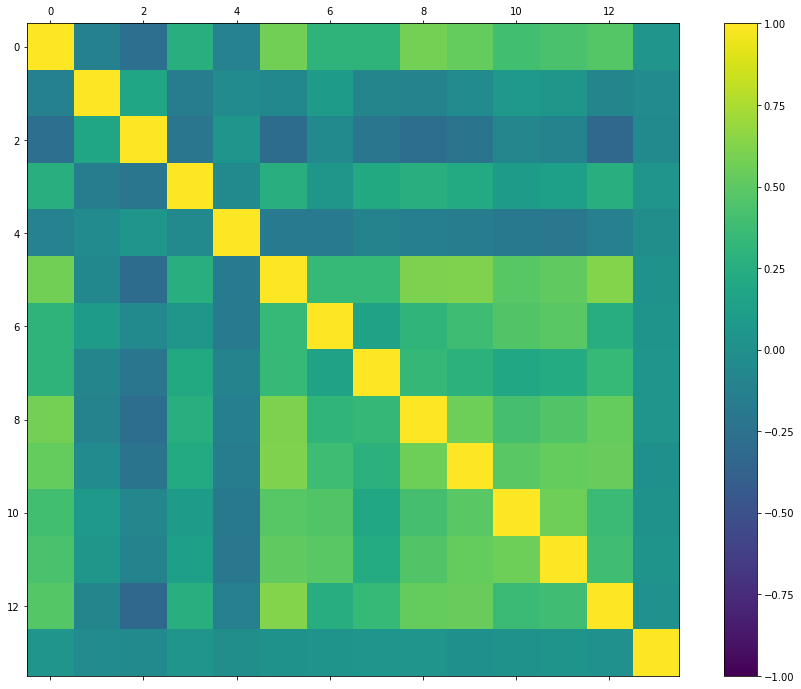

In [25]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = df_features_train.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [26]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [27]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Test Sets

In [28]:
# Not applicable for this iteration of the project

### 3.b) Feature Scaling and Data Pre-Processing

In [29]:
# Compose pipeline for the numerical and categorical features (Block #1 of 2)
numeric_columns = df_features_train.select_dtypes(include=['int64','float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', impute.SimpleImputer(strategy='constant', fill_value=0))
#     ('scaler', preprocessing.StandardScaler())
])
categorical_columns = df_features_train.select_dtypes(include=['object','bool']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', impute.SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the feature dataframe:", df_features_train.shape[1])

Number of numerical columns: 14
Number of categorical columns: 10
Total number of columns in the feature dataframe: 24


In [30]:
# Compose pipeline for the numerical and categorical features (Block #2 of 2)
preprocessor = compose.ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('cat', categorical_transformer, categorical_columns)
])

# Display the shapes of the training dataset for final inspection
array_features_train = preprocessor.fit_transform(df_features_train)
print("Transformed features from df_features_train.shape: {} to array_features_train.shape: {}".format(df_features_train.shape, array_features_train.shape))

Transformed features from df_features_train.shape: (300000, 24) to array_features_train.shape: (300000, 70)


### 3.c) Training Data Balancing

In [31]:
# Not applicable for this iteration of the project

### 3.d) Feature Selection

In [32]:
# Not applicable for this iteration of the project

### 3.e) Display the Final Datasets for Model-Building

In [33]:
# # Finalize the training and validation datasets for the modeling activities
# array_features_train = df_features_train.to_numpy()
array_target_train = df_target_train.ravel()
print("array_features_train.shape: {} array_target_train.shape: {}".format(array_features_train.shape, array_target_train.shape))

array_features_train.shape: (300000, 70) array_target_train.shape: (300000,)


In [34]:
if NOTIFY_STATUS: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [35]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [36]:
# Set up Algorithms Spot-Checking Array
start_time_training = datetime.now()
start_time_module = datetime.now()
train_models = []
train_results = []
train_model_names = []
train_metrics = []
train_models.append(('LNR', LinearRegression(n_jobs=N_JOBS)))
train_models.append(('ELN', ElasticNet(random_state=RNG_SEED)))
train_models.append(('KNN', KNeighborsRegressor(n_jobs=N_JOBS)))
train_models.append(('RNF', RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('EXT', ExtraTreesRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)))
train_models.append(('GBM', GradientBoostingRegressor(random_state=RNG_SEED)))

In [37]:
# Generate model in turn
for name, model in train_models:
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	start_time_module = datetime.now()
	kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
	cv_results = cross_val_score(model, array_features_train, array_target_train, cv=kfold, scoring=SCORING_METRIC, n_jobs=N_JOBS, verbose=1)
	train_results.append(cv_results)
	train_model_names.append(name)
	train_metrics.append(cv_results.mean())
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - start_time_module), '\n')
	if NOTIFY_STATUS: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
print ('Average metrics (' + SCORING_METRIC + ') from all models:',np.mean(train_metrics))
print ('Average RMSE for all models is:', math.sqrt((np.mean(train_metrics)*-1)))
print ('Total training time for all models:',(datetime.now() - start_time_training))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    7.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


LNR: -0.746187 (0.006595)
LinearRegression(n_jobs=4)
Model training time: 0:00:07.761349 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


ELN: -0.787294 (0.006305)
ElasticNet(random_state=888)
Model training time: 0:00:01.536491 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 22.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


KNN: -0.891587 (0.005042)
KNeighborsRegressor(n_jobs=4)
Model training time: 0:22:03.135928 

RNF: -0.736172 (0.006630)
RandomForestRegressor(n_jobs=4, random_state=888)
Model training time: 0:25:28.891340 



[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 25.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 11.5min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


EXT: -0.748060 (0.006029)
ExtraTreesRegressor(n_jobs=4, random_state=888)
Model training time: 0:11:30.796415 

GBM: -0.727541 (0.006936)
GradientBoostingRegressor(random_state=888)
Model training time: 0:14:55.950237 

Average metrics (neg_mean_squared_error) from all models: -0.7728067664762603
Average RMSE for all models is: 0.8790942875916441
Total training time for all models: 1:14:08.098250


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed: 14.9min finished


### 4.b) Spot-checking baseline algorithms

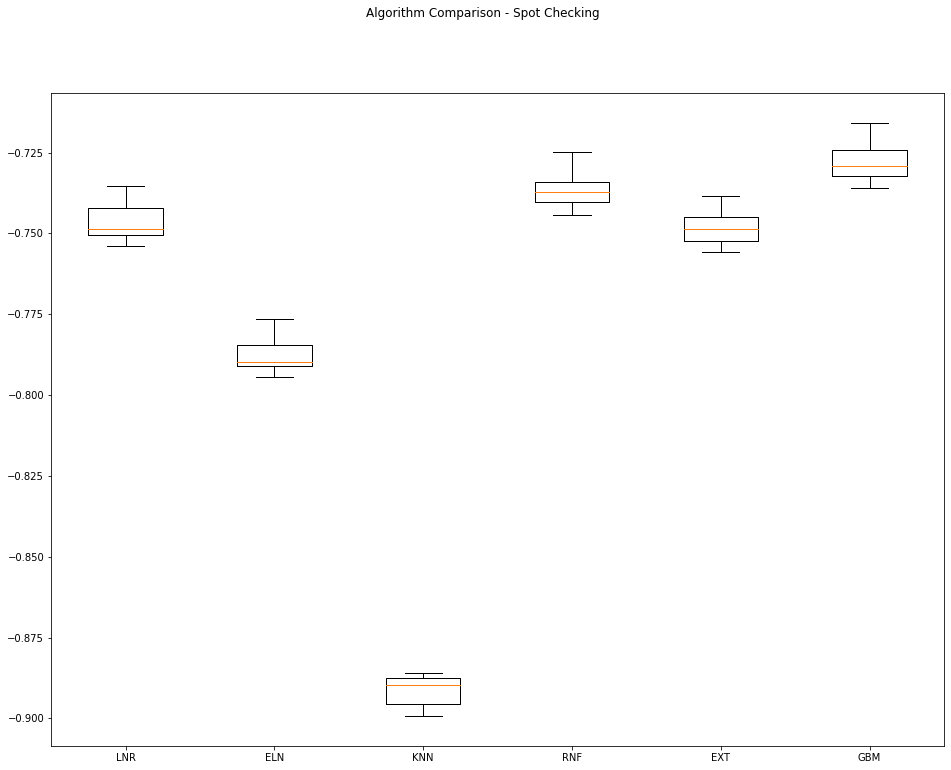

In [38]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Spot Checking')
ax = fig.add_subplot(111)
plt.boxplot(train_results)
ax.set_xticklabels(train_model_names)
plt.show()

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Fine-tune and Improve Models

In [40]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Algorithm Tuning

In [41]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [42]:
# Tuning algorithm #1 - Extra Trees
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('RNF')
tune_model1 = RandomForestRegressor(random_state=RNG_SEED, n_jobs=N_JOBS)
paramGrid1 = dict(n_estimators=np.array([100, 300, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result1 = grid1.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result1.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #1 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: -0.730150 using {'n_estimators': 500}
-0.736172 (0.006630) with: {'n_estimators': 100}
-0.731129 (0.006709) with: {'n_estimators': 300}
-0.730150 (0.006601) with: {'n_estimators': 500}
Best RMSE for the Model is: 0.8544878895267655
Model training time: 4:10:08.599727


In [43]:
best_paramKey1 = list(grid_result1.best_params_.keys())[0]
best_paramValue1 = list(grid_result1.best_params_.values())[0]
print("Captured the best parameter for algorithm #1:", best_paramKey1, '=', best_paramValue1)

Captured the best parameter for algorithm #1: n_estimators = 500


In [44]:
# Tuning algorithm #2 - Gradient Boosting
start_time_module = datetime.now()
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model_names.append('GBM')
tune_model2 = GradientBoostingRegressor(random_state=RNG_SEED)
paramGrid2 = dict(n_estimators=np.array([100, 300, 500]))

kfold = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RNG_SEED)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=SCORING_METRIC, cv=kfold, n_jobs=N_JOBS, verbose=1)
grid_result2 = grid2.fit(array_features_train, array_target_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Best RMSE for the Model is:', math.sqrt((grid_result2.best_score_*-1)))
print ('Model training time:',(datetime.now() - start_time_module))
if NOTIFY_STATUS: status_notify("Algorithm #2 tuning completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: -0.713519 using {'n_estimators': 500}
-0.727541 (0.006936) with: {'n_estimators': 100}
-0.716085 (0.006716) with: {'n_estimators': 300}
-0.713519 (0.006479) with: {'n_estimators': 500}
Best RMSE for the Model is: 0.844700307585305
Model training time: 2:30:15.221709


In [45]:
best_paramKey2 = list(grid_result2.best_params_.keys())[0]
best_paramValue2 = list(grid_result2.best_params_.values())[0]
print("Captured the best parameter for algorithm #2:", best_paramKey2, '=', best_paramValue2)

Captured the best parameter for algorithm #2: n_estimators = 500


### 5.b) Compare Algorithms After Tuning

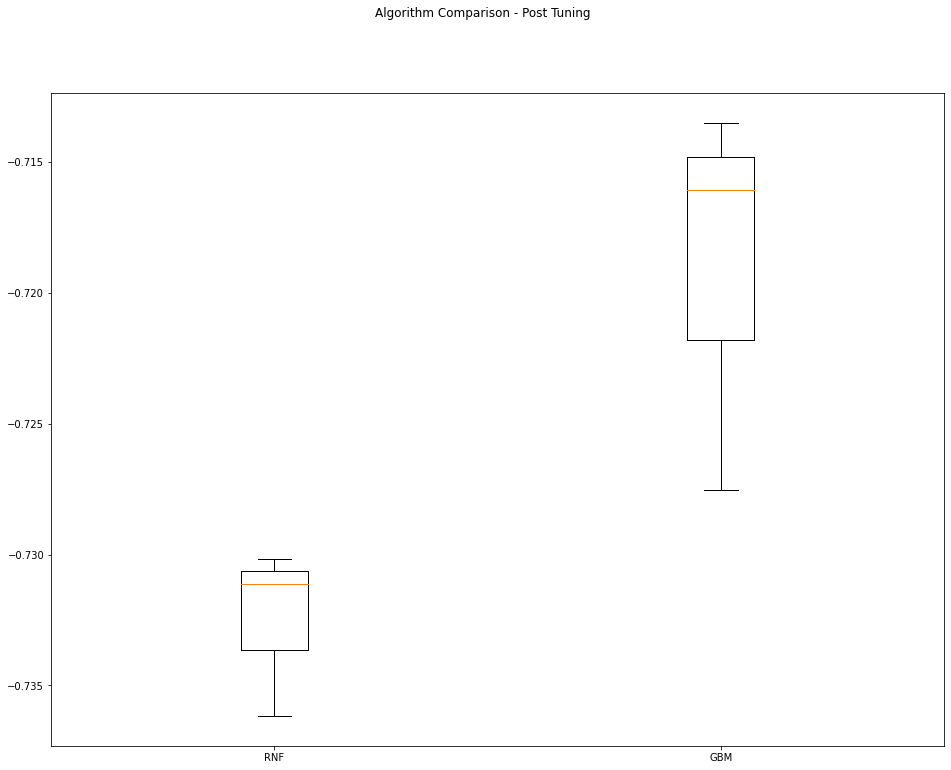

In [46]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 6 - Finalize Model and Present Analysis

In [48]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 6.a) Train the Final Model

In [49]:
final_model = GradientBoostingRegressor(n_estimators=best_paramValue2, random_state=RNG_SEED)
final_model.fit(array_features_train, array_target_train)
print(final_model)

GradientBoostingRegressor(n_estimators=500, random_state=888)


### 6.b) Load Test Dataset and Prepare the Submission File

In [50]:
dataset_path = 'https://dainesanalytics.com/datasets/kaggle-tabular-playground-2021feb/test.csv'
df_features_test = pd.read_csv(dataset_path, index_col=False)

# Take a peek at the dataframe after import
print(df_features_test.head())

   id cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8  ...     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11  \
0   0    A    B    A    C    B    D    A    E    E  ...  0.701679  0.595507  0.286912  0.279884  0.202234  0.242654  0.285147  0.264308   
1   5    A    B    A    C    B    D    A    E    C  ...  0.277480  0.479552  0.397436  0.476742  0.857073  0.516393  0.562065  0.730542   
2  15    A    B    A    C    B    D    A    E    C  ...  0.279508  0.676395  0.695284  0.253316  0.586934  0.548555  0.836193  0.759788   
3  16    A    A    B    A    B    D    A    E    E  ...  0.479503  0.759875  0.240049  0.298074  0.442475  0.596746  0.414131  0.255382   
4  17    A    B    A    A    B    B    A    E    E  ...  0.757845  0.210232  0.329851  0.616663  0.170475  0.263235  0.710961  0.224045   

     cont12    cont13  
0  0.653654  0.302448  
1  0.318492  0.736251  
2  0.333572  0.273905  
3  0.589080  0.311625  
4  0.285860  0.794931  

[5 rows x 25 columns

In [51]:
df_kaggle_submission = pd.DataFrame()
df_kaggle_submission['id'] = df_features_test['id']
print(df_kaggle_submission.head())

   id
0   0
1   5
2  15
3  16
4  17


In [52]:
# Dropping features
df_features_test.drop(columns=['id'], inplace=True)

# Take a peek at the dataframe after cleaning
print(df_features_test.head())

  cat0 cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont4     cont5     cont6     cont7     cont8     cont9    cont10    cont11  \
0    A    B    A    C    B    D    A    E    E    G  ...  0.701679  0.595507  0.286912  0.279884  0.202234  0.242654  0.285147  0.264308   
1    A    B    A    C    B    D    A    E    C    L  ...  0.277480  0.479552  0.397436  0.476742  0.857073  0.516393  0.562065  0.730542   
2    A    B    A    C    B    D    A    E    C    F  ...  0.279508  0.676395  0.695284  0.253316  0.586934  0.548555  0.836193  0.759788   
3    A    A    B    A    B    D    A    E    E    F  ...  0.479503  0.759875  0.240049  0.298074  0.442475  0.596746  0.414131  0.255382   
4    A    B    A    A    B    B    A    E    E    I  ...  0.757845  0.210232  0.329851  0.616663  0.170475  0.263235  0.710961  0.224045   

     cont12    cont13  
0  0.653654  0.302448  
1  0.318492  0.736251  
2  0.333572  0.273905  
3  0.589080  0.311625  
4  0.285860  0.794931  

[5 rows x 24 c

In [53]:
# Display the shapes of the training dataset for final inspection
array_features_test = preprocessor.transform(df_features_test)
print("Transformed features from df_features_test.shape: {} to array_features_test.shape: {}".format(df_features_test.shape, array_features_test.shape))

Transformed features from df_features_test.shape: (200000, 24) to array_features_test.shape: (200000, 70)


In [54]:
# Make batched predictions
test_predictions = final_model.predict(array_features_test)
print(test_predictions)

[7.60650557 7.71212887 7.60363328 ... 7.53286067 7.46482212 7.33111215]


In [55]:
df_kaggle_submission['target'] = test_predictions
print(df_kaggle_submission.head())

   id    target
0   0  7.606506
1   5  7.712129
2  15  7.603633
3  16  7.433518
4  17  7.272547


In [56]:
submission_file = df_kaggle_submission.to_csv(header=True, index=False)
filename = 'submission_' + datetime.now().strftime('%Y%m%d-%H%M') + '.csv'
with open(filename, 'w') as f:
    f.write(submission_file)
    print('Completed writing output file: ' + filename)

Completed writing output file: submission_20210522-0844.csv


In [57]:
if NOTIFY_STATUS: status_notify("Task 6 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [58]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 8:39:48.358087
